In [1]:
import sys
sys.path.insert(0,'/data1/aditya/broditya/lib/python2.7/site-packages/')
import torch
torch.__version__

'0.4.1'

In [288]:
# test the perfomance on different data samples here
import torch
import torch.backends.cudnn as cudnn
import data_loaders.data_loader_conditioned as data_loader
import utils
import global_variables as gv
# import models.multilinear_complex_GRU as GRU
import models.simple_GRU as GRU
import argparse
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device_id = 0
torch.cuda.set_device(device_id)
wt_load = 'weights/best_FinalSimpleGRU.pth'
# wt_load = "NIL"
loader = 'val'
reload(utils)
reload(GRU)

<module 'models.simple_GRU' from 'models/simple_GRU.pyc'>

In [289]:
y = load['model_state_dict']
print(y.keys())
y['gru_1.weight_hh_l0'].size()

['gru_1.weight_ih_l0', 'gru_1.weight_hh_l0', 'gru_1.bias_ih_l0', 'gru_1.bias_hh_l0', 'gru_2.weight_ih_l0', 'gru_2.weight_hh_l0', 'gru_2.bias_ih_l0', 'gru_2.bias_hh_l0', 'linear_1.weight', 'linear_1.bias', 'linear_2.weight', 'linear_2.bias', 'go.softmax_loss.weight']


torch.Size([1200, 400])

In [290]:

train_data_loader = data_loader.dataloader(gv.batch_limit,gv.train_start_index,gv.train_end_index)
val_data_loader = data_loader.dataloader(gv.batch_limit,gv.val_start_index,gv.val_end_index)
# network = GRU.network(3,400,400,400,122)
# network = GRU.network(3,256,512,256,122)
network = GRU.network(3,400,122)
network.cuda()
# init the network with orthogonal init and gluroot.
if wt_load=="NIL":
    network.wt_init()
else:
    load = torch.load(wt_load)
    network.load_state_dict(load['model_state_dict'])
    # load wts if required.

# for le rumours 
cudnn.benchmark = True


In [291]:
if loader == 'train':
    data_fetcher = train_data_loader.get_data_single()
else:
    data_fetcher = val_data_loader.get_data_single()
  

In [292]:
data,data_gt,char = next(data_fetcher)
cat_target = np.concatenate(data_gt[:1],axis=0)
x_gt = torch.autograd.Variable(torch.FloatTensor(cat_target[:,1]).cuda())
y_gt = torch.autograd.Variable(torch.FloatTensor(cat_target[:,2]).cuda())
pen_down_gt = torch.autograd.Variable(torch.LongTensor(cat_target[:,0]).cuda())

In [293]:

output = network.forward_unlooped(data,char,cuda=True)
pen_down_prob,o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr = network.go.get_mixture_coef(output)
loss_distr,pen_loss = network.go.loss_distr(pen_down_prob,o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, x_gt, y_gt,pen_down_gt)
predicted_action = network.go.sample_action(pen_down_prob,o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr,no_sigma=False)
loss_l2,pen_acc = network.go.val_loss(predicted_action, x_gt, y_gt,pen_down_gt)

In [294]:
print('loss_l2',loss_l2)
pred = predicted_action.cpu().numpy()
gt = data_gt[0]
print(pred.shape,gt.shape)

('loss_l2', tensor(0.6684, device='cuda:0'))
((721, 3), (721, 3))


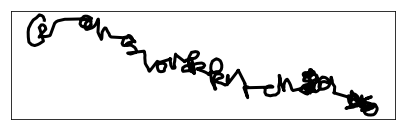

In [295]:
# the pred
#pred[:,0] = gt[:,0]
pred_image = utils.plot_stroke(pred)# .transpose(2,0,1)
# plt.figure()
# plt.imshow(pred_image)

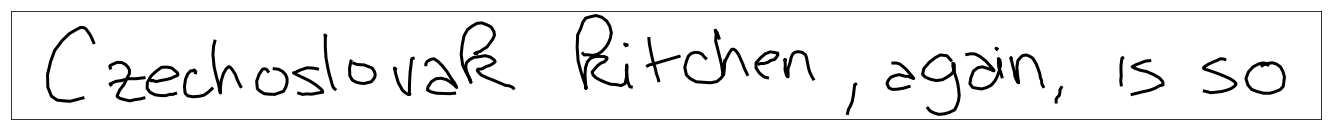

In [296]:
# the gt
gt_image = utils.plot_stroke(gt)# .transpose(2,0,1)
# plt.imshow(gt_image)

In [297]:
# self generation
output = network.forward_looped(1,700,no_sigma=False)
output.size()

torch.Size([700, 1, 3])

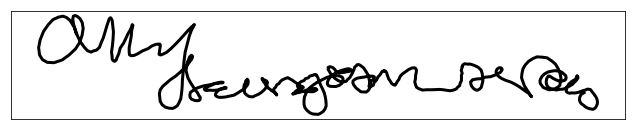

In [298]:

pred = output[:,0,:].cpu().numpy()
pred[:,0] = 0
pred_image = utils.plot_stroke(pred)# .transpose(2,0,1)
# pred = output[:,1,:].cpu().numpy()
# pred_image = utils.plot_stroke(pred)# .transpose(2,0,1)
# pred = output[:,2,:].cpu().numpy()
# pred_image = utils.plot_stroke(pred)# .transpose(2,0,1)